<h1>Compression time series with RNN autoencoder</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import sys
import time
from tqdm import tqdm

## Create timeseries dataset

In [2]:
time = np.linspace(0, 10000, 100000)                    # Время: от 0 до 100, 1000 точек
amplitude = np.sin(2 * np.pi * 0.1 * time)          # Основная синусоида
noise = np.random.normal(0, 0.3, size=len(time))    # Добавление шума
signal = amplitude + noise                          # Итоговый временной ряд
amplitude2 = np.sin(2 * np.pi * 0.3 * time)             
amplitude3 = np.cos(2 * np.pi * 0.3 * time)
signal = amplitude + noise  + amplitude2  + amplitude3    # Итоговый временной ряд

signal = signal.astype('float32')

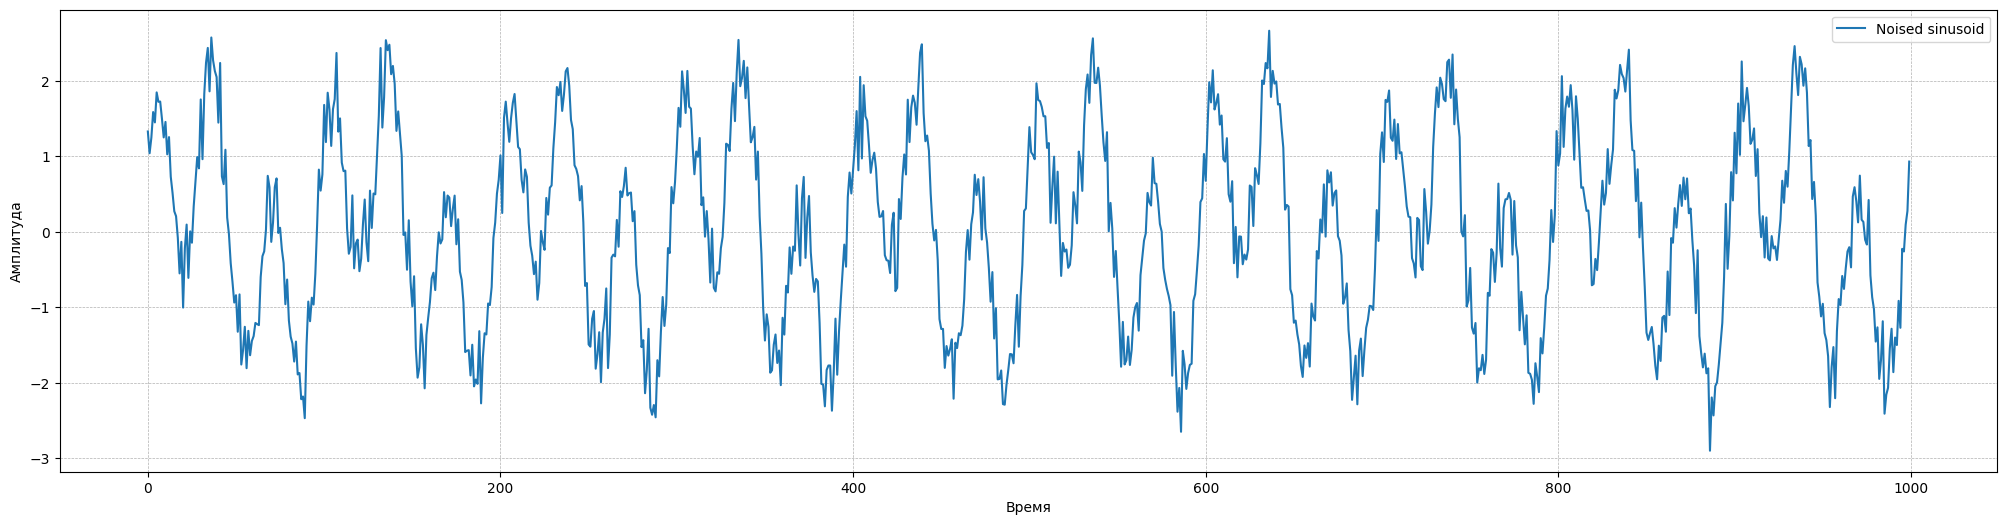

In [3]:
plt.figure(figsize=(25, 6))
plt.plot(signal[:1000], label="Noised sinusoid")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [4]:
def plot_sinusoid(signal):
    plt.figure(figsize=(25, 6))
    plt.plot(signal, label="Noised sinusoid")
    plt.xlabel("Время")
    plt.ylabel("Амплитуда")
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

def split_time_series(signal, min_length, max_length):
    segments = []
    i = 0
    while i < len(signal):
        segment_length = np.random.randint(min_length, max_length + 1)
        if i + segment_length > len(signal):
            break
        segments.append(signal[i:i + segment_length])
        i += segment_length
    return segments

sequences = split_time_series(signal, min_length=600, max_length=900)

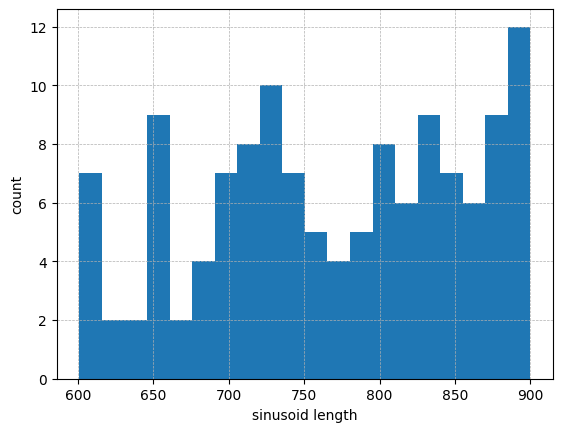

In [5]:
segments_info = [len(x) for x in sequences]

plt.hist(segments_info, bins=20) 
plt.xlabel("sinusoid length")
plt.ylabel("count")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [6]:
len(sequences)

129

In [7]:
# Функция для разбиения на перекрывающиеся сегменты
def split_with_overlap(sequence, window_size=60, step=1):
    '''
    Split sequence on crossed segments

    Args:
        sequence (np.ndarray): Input sequence
        window_size (int): Window size (segment length)
        step (int): Split step
    
    Returns:
        List[np.ndarray]: segments list
    '''
    segments = []
    for i in range(0, len(sequence) - window_size + 1, step):
        segment = sequence[i:i + window_size]
        segments.append(segment)
    return segments


class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, window_size=60, step=1):
        '''
        Dataset initialization

        Args:
            sequences (List[np.ndarray]): time serieses list
            window_size (int): window size (segment length)
            step (int): split step
        '''
        self.segments = []
        for seq in sequences:
            segs = split_with_overlap(seq, window_size, step)
            self.segments.extend(segs)
        
    
    def __len__(self):
        return len(self.segments)


    def __getitem__(self, idx):
        segment = self.segments[idx]
        return torch.tensor(segment, dtype=torch.float32).unsqueeze(-1)
    

# Splitting data on train, validation and test
train_size = int(len(sequences) * 0.7)
val_size = int(len(sequences) * 0.15)

train_seqs = sequences[:train_size]
val_seqs = sequences[train_size: train_size + val_size]
test_seqs = sequences[train_size + val_size:]

print(f'train_seqs: {len(train_seqs)} val_seqs: {len(val_seqs)} test_seqs: {len(test_seqs)}')


# Creating datasets
window_size = 60
step = 1
train_dataset = TimeSeriesDataset(train_seqs, window_size, step)
val_dataset = TimeSeriesDataset(val_seqs, window_size, step)
test_dataset = TimeSeriesDataset(test_seqs, window_size, step)

print(f'train_dataset: {len(train_dataset)} val_dataset: {len(val_dataset)} test_dataset: {len(test_dataset)}')

# Creating dataloaders
segment_batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=segment_batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=segment_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=segment_batch_size, shuffle=False)

tensor = next(iter(train_loader))
print(tensor.shape)

train_seqs: 90 val_seqs: 19 test_seqs: 20
train_dataset: 63877 val_dataset: 13499 test_dataset: 14237
torch.Size([64, 60, 1])


## LSTM autoencoder

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [17]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, latent_dim=64, num_layers=1):
        super().__init__()
        # Encoder
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.encoder_fc = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder_output = nn.Linear(hidden_dim, input_dim)
    

    def forward(self, x):
        # Encoder
        _, (hidden, _) = self.encoder_lstm(x)           # hidden: (num_layers, batch, hidden_dim)
        latent = self.encoder_fc(hidden[-1])            # latent: (batch, latent_dim)

        # Decoder
        decoder_hidden = self.decoder_fc(latent).unsqueeze(0)        # decoder_hidden: (num_layers, batch, hidden_dim)
        decoder_input = torch.zeros(x.size(0), x.size(1), self.decoder_lstm.input_size, device=x.device)
        decoder_output, _ = self.decoder_lstm(decoder_input, (decoder_hidden, torch.zeros_like(decoder_hidden)))
        output = self.decoder_output(decoder_output)                 # (batch, seq_len, input_dim)

        return output, latent


# Initialization model
num_features = 1
hidden_dim = 128
latent_dim = 10

model = LSTMAutoencoder(input_dim=num_features, hidden_dim=hidden_dim, latent_dim=latent_dim)
model = model.to(device)

# Loss function and optimizer 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)


LSTMAutoencoder(
  (encoder_lstm): LSTM(1, 128, batch_first=True)
  (encoder_fc): Linear(in_features=128, out_features=10, bias=True)
  (decoder_fc): Linear(in_features=10, out_features=128, bias=True)
  (decoder_lstm): LSTM(128, 128, batch_first=True)
  (decoder_output): Linear(in_features=128, out_features=1, bias=True)
)


In [18]:
tensor = tensor.to(device)
reconstructed, latent = model(tensor)
print(reconstructed.shape, latent.shape)

torch.Size([64, 60, 1]) torch.Size([64, 10])


### Training model

In [19]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()       # transit model to training mode
    train_loss = 0.0    # total loss on training data

    # Progress bar for training loop
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training', leave=False, file=sys.stdout)

    for batch in train_bar:
        batch = batch.to(device)        # (batch_size, seq_len, input_dim)
        optimizer.zero_grad()
        reconstructed, latent = model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)

        # Update progress bar in tqdm
        train_bar.set_postfix({'Batch Loss': loss.item()})

    
    avg_train_loss = train_loss / len(train_loader.dataset)

    # Validation
    model.eval()    # transit model to validation mode
    val_loss = 0    # total loss on validation data

    val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation', leave=False, file=sys.stdout)


    with torch.no_grad():
        for batch in val_bar:
            batch = batch.to(device)
            reconstructed, latent = model(batch)
            loss = criterion(reconstructed, batch)
            val_loss += loss.item() * batch.size(0)

            val_bar.set_postfix({'Batch Loss': loss.item()})
    
    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    

Epoch [1/50], Train Loss: 0.5501, Val Loss: 0.1044                                            
Epoch [2/50], Train Loss: 0.1543, Val Loss: 0.5847                                           
Epoch [3/50], Train Loss: 0.4569, Val Loss: 0.3009                                           
Epoch [4/50], Train Loss: 0.4210, Val Loss: 0.4291                                           
Epoch [5/50], Train Loss: 0.2981, Val Loss: 0.6616                                           
Epoch [6/50], Train Loss: 0.1668, Val Loss: 0.0976                                            
Epoch [7/50], Train Loss: 0.0965, Val Loss: 0.0968                                            
Epoch [8/50], Train Loss: 0.0948, Val Loss: 0.1000                                            
Epoch [9/50], Train Loss: 0.1192, Val Loss: 0.0944                                            
Epoch [10/50], Train Loss: 0.0941, Val Loss: 0.1071                                            
Epoch [11/50], Train Loss: 0.0935, Val Loss: 0.1046  

In [20]:
# Оценка на тестовой выборке
model.eval()  # Перевод модели в режим оценки
test_loss = 0.0  # Суммарная потеря на тестовой выборке
test_bar = tqdm(test_loader, desc='Testing', leave=False)
with torch.no_grad():
    for batch in test_bar:
        batch = batch.to(device)  # Перемещение данных на устройство
        reconstructed, latent = model(batch)  # Прямой проход через модель
        loss = criterion(reconstructed, batch)  # Вычисление потерь
        test_loss += loss.item() * batch.size(0)  # Суммирование потерь

        # Обновление прогресса в tqdm
        test_bar.set_postfix({'Batch Loss': loss.item()})

avg_test_loss = test_loss / len(test_loader.dataset)  # Средняя потеря на тестовой выборке
print(f'Test Loss: {avg_test_loss:.6f}')

Test Loss: 0.096665


## Reconstructed data

In [21]:
# Функция для получения латентных представлений для полной последовательности
def get_latent_representations(model, sequence, window_size=60, step=1, segment_batch_size=64):
    """
    Получает латентные представления для полной последовательности.

    Args:
        model (nn.Module): Обученная модель автоэнкодера.
        sequence (numpy.ndarray): Исходная последовательность.
        window_size (int): Размер окна для разбиения на сегменты.
        step (int): Шаг разбиения на сегменты.
        segment_batch_size (int): Размер батча для обработки сегментов.

    Returns:
        numpy.ndarray: Латентные представления всех сегментов.
    """
    model.eval()
    segments = split_with_overlap(sequence, window_size, step)
    # Преобразуем сегменты в тензоры и добавляем размерности для батча и признаков
    segments = [torch.tensor(seg, dtype=torch.float32).unsqueeze(-1) for seg in segments]  # (seq_len, 1)

    # Создание DataLoader для сегментов
    dataloader = DataLoader(segments, batch_size=segment_batch_size, shuffle=False)

    latent_vectors = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Extracting Latent Vectors', leave=False):
            batch = batch.to(device)  # (batch_size, seq_len, input_dim)
            _, latent = model(batch)   # latent: (batch_size, latent_dim)
            latent_vectors.append(latent.cpu().numpy())
    
    # Объединяем все латентные векторы
    latent_vectors = np.concatenate(latent_vectors, axis=0)  # (num_segments, latent_dim)
    return np.mean(latent_vectors, axis=0)

def reconstruct_sequence(model, sequence, window_size=60, step=1, segment_batch_size=64):
    """
    Восстанавливает полную последовательность из реконструированных сегментов.

    Args:
        model (nn.Module): Обученная модель автоэнкодера.
        sequence (numpy.ndarray): Исходная последовательность.
        window_size (int): Размер окна для разбиения на сегменты.
        step (int): Шаг разбиения на сегменты.
        segment_batch_size (int): Размер батча для обработки сегментов.

    Returns:
        numpy.ndarray: Восстановленная последовательность.
    """
    model.eval()  # Перевод модели в режим оценки
    segments = split_with_overlap(sequence, window_size, step)
    # Преобразуем сегменты в тензоры и добавляем размерности для батча и признаков
    segments = [torch.tensor(seg, dtype=torch.float32).unsqueeze(-1) for seg in segments]  # (seq_len, 1)

    # print(len(segments), segments[0].shape)
    # Создание DataLoader для сегментов
    dataloader = DataLoader(segments, batch_size=segment_batch_size, shuffle=False)
    # print(next(iter(dataloader)).shape)

    reconstructed_segments = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Reconstructing Segments', leave=False):
            batch = batch.to(device)  # (batch_size, seq_len, input_dim)
            reconstructed, _ = model(batch)  # reconstructed: (batch_size, seq_len, input_dim)
            reconstructed_segments.append(reconstructed.cpu().numpy())
    
    # Объединяем все реконструированные сегменты
    reconstructed_segments = np.concatenate(reconstructed_segments, axis=0)  # (num_segments, seq_len, input_dim)
    
    # Инициализация массивов для суммирования и подсчёта перекрытий
    total_length = len(sequence)
    reconstructed_sequence = np.zeros(total_length, dtype=np.float32)
    count = np.zeros(total_length, dtype=np.float32)
    
    for i, seg in enumerate(reconstructed_segments):
        start = i * step
        end = start + window_size
        if end > total_length:
            end = total_length
            seg = seg[:end - start, :]  # Корректировка размера сегмента, если он выходит за пределы последовательности
        reconstructed_sequence[start:end] += seg[:end - start, 0]
        count[start:end] += 1.0
    
    # Усреднение значений в местах перекрытия
    reconstructed_sequence /= count
    return reconstructed_sequence

def evaluate_reconstruction(model, test_sequences, window_size=60, step=1, segment_batch_size=64):
    """
    Восстанавливает и оценивает качество реконструкции для тестовых последовательностей.

    Args:
        model (nn.Module): Обученная модель автоэнкодера.
        test_sequences (List[numpy.ndarray]): Список тестовых последовательностей.
        window_size (int): Размер окна для разбиения на сегменты.
        step (int): Шаг разбиения на сегменты.
        segment_batch_size (int): Размер батча для обработки сегментов.

    Returns:
        float: Среднее значение MSE на тестовой выборке.
    """
    mse_total = 0.0  # Суммарное значение MSE
    num_elements = 0  # Общее количество элементов

    for seq in tqdm(test_sequences, desc='Reconstructing Sequences'):
        reconstructed_seq = reconstruct_sequence(model, seq, window_size, step, segment_batch_size)
        mse = np.mean((reconstructed_seq - seq) ** 2)
        mse_total += mse * len(seq)
        num_elements += len(seq)
    
    avg_mse = mse_total / num_elements
    return avg_mse

# Оценка качества реконструкции на тестовой выборке
test_reconstruction_mse = evaluate_reconstruction(model, test_seqs, window_size, step, segment_batch_size)
print(f'Test Reconstruction MSE: {test_reconstruction_mse:.6f}')

Reconstructing Sequences:   0%|          | 0/20 [00:00<?, ?it/s]

Reconstructing Sequences: 100%|██████████| 20/20 [00:01<00:00, 13.82it/s]

Test Reconstruction MSE: 0.094712


Restoring Sequences: 100%|██████████| 20/20 [00:01<00:00, 14.86it/s]


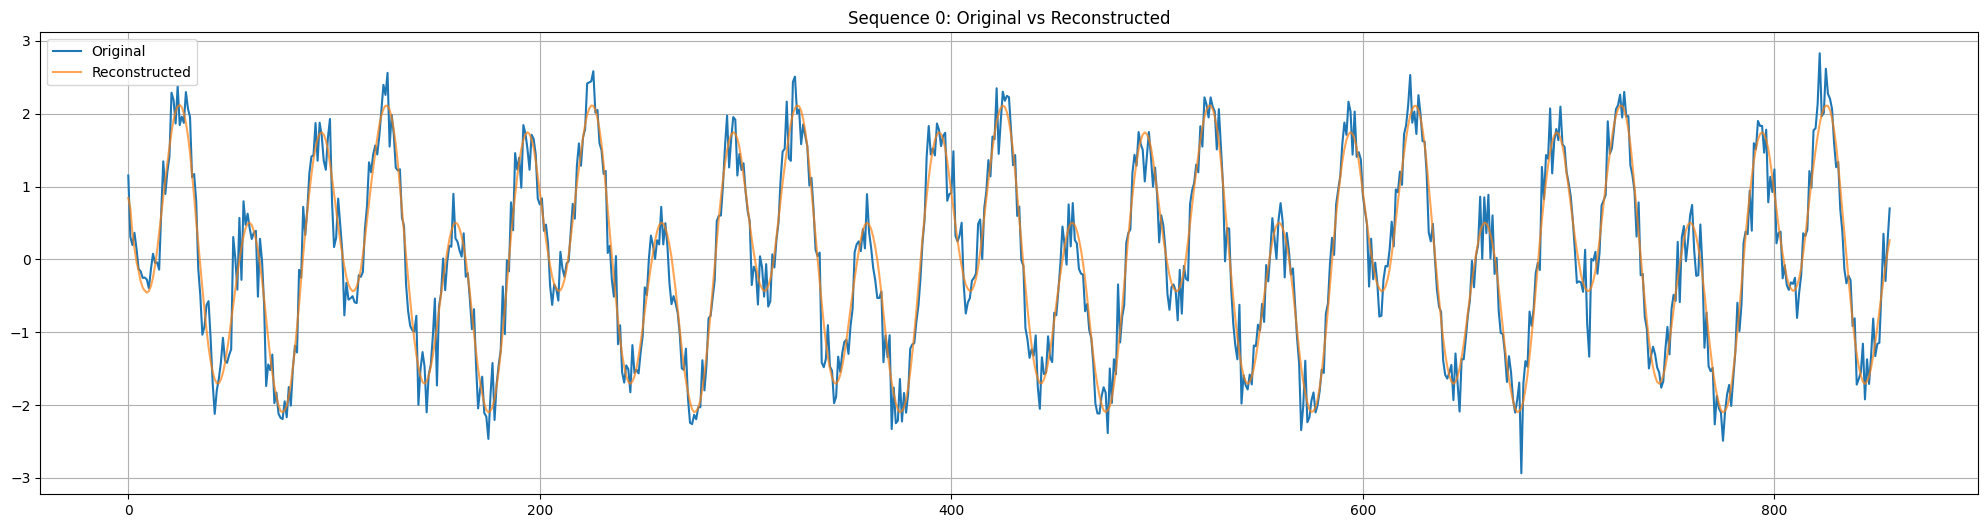

In [22]:
# Функция для восстановления всех тестовых последовательностей
def restore_test_sequences(model, test_sequences, window_size=60, step=1, segment_batch_size=64):
    """
    Восстанавливает все тестовые последовательности.

    Args:
        model (nn.Module): Обученная модель автоэнкодера.
        test_sequences (List[numpy.ndarray]): Список тестовых последовательностей.
        window_size (int): Размер окна для разбиения на сегменты.
        step (int): Шаг разбиения на сегменты.
        segment_batch_size (int): Размер батча для обработки сегментов.

    Returns:
        List[numpy.ndarray]: Список восстановленных последовательностей.
    """
    reconstructed_sequences = []
    for seq in tqdm(test_sequences, desc='Restoring Sequences'):
        reconstructed_seq = reconstruct_sequence(model, seq, window_size, step, segment_batch_size)
        reconstructed_sequences.append(reconstructed_seq)
    return reconstructed_sequences

# Восстановление всех тестовых последовательностей
restored_test_sequences = restore_test_sequences(model, test_seqs, window_size, step, segment_batch_size)

# Пример сравнения оригинальной и восстановленной последовательности

def plot_reconstruction(original, reconstructed, index=0):
    """
    Строит график оригинальной и восстановленной последовательности.

    Args:
        original (numpy.ndarray): Оригинальная последовательность.
        reconstructed (numpy.ndarray): Восстановленная последовательность.
        index (int): Индекс последовательности для отображения.
    """
    plt.figure(figsize=(25, 6))
    plt.plot(original, label='Original')
    plt.plot(reconstructed, label='Reconstructed', alpha=0.7)
    plt.title(f'Sequence {index}: Original vs Reconstructed')
    plt.grid()
    plt.legend()
    plt.show()

# Визуализация первой тестовой последовательности
if len(restored_test_sequences) > 0:
    plot_reconstruction(test_seqs[4], restored_test_sequences[4], index=0)


In [23]:
test_latent = get_latent_representations(model, test_seqs[4], window_size=60, step=1, segment_batch_size=64)

Extracting Latent Vectors:   0%|          | 0/13 [00:00<?, ?it/s]

In [24]:
test_latent.shape, test_seqs[4].shape

((10,), (857,))

In [25]:
test_latent

array([ 1.3733374 ,  0.11110492,  0.6681537 , -1.1394482 , -0.12161605,
        0.17389454,  0.96524185,  0.05530605, -0.94102293, -0.6979516 ],
      dtype=float32)